In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional, GRU, TimeDistributed
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [17]:
main_folder = r"C:\Resume_projects\flute_teaching_kit\data\processed_data"
X, y = [], []

for note in sorted(os.listdir(main_folder)):  
    note_path = os.path.join(main_folder, note)
    
    if os.path.isdir(note_path):
        for file in sorted(os.listdir(note_path)):
            if file.endswith(".npy"):
                data = np.load(os.path.join(note_path, file))
                X.append(data)
                y.append(note)

X = np.array(X) / np.max(X)
y = LabelEncoder().fit_transform(y)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

In [19]:
X_train = X_train[..., np.newaxis]  
X_val = X_val[..., np.newaxis]

input_shape = X_train.shape[1:]

In [20]:
model = Sequential([
    tf.keras.Input(shape=input_shape),

    # CNN Layers
    Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    TimeDistributed(Flatten()),

    # RNN Layer
    Bidirectional(GRU(32, return_sequences=False)),

    # Fully Connected Layers
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')  
])

In [21]:
# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 🔹 Train Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.1734 - loss: 2.1851 - val_accuracy: 0.1200 - val_loss: 2.1304
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3213 - loss: 1.8709 - val_accuracy: 0.2489 - val_loss: 2.1279
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.4208 - loss: 1.6471 - val_accuracy: 0.1289 - val_loss: 2.1892
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5394 - loss: 1.3952 - val_accuracy: 0.1244 - val_loss: 2.3851
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.6460 - loss: 1.1581 - val_accuracy: 0.1156 - val_loss: 2.6672
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7066 - loss: 0.9452 - val_accuracy: 0.1156 - val_loss: 3.0688
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7788 - loss: 0.7891 - val_accuracy: 0.1156 - val_loss: 3.3498
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8251 - loss: 0.6495 - val_accuracy: 0.1156 - v

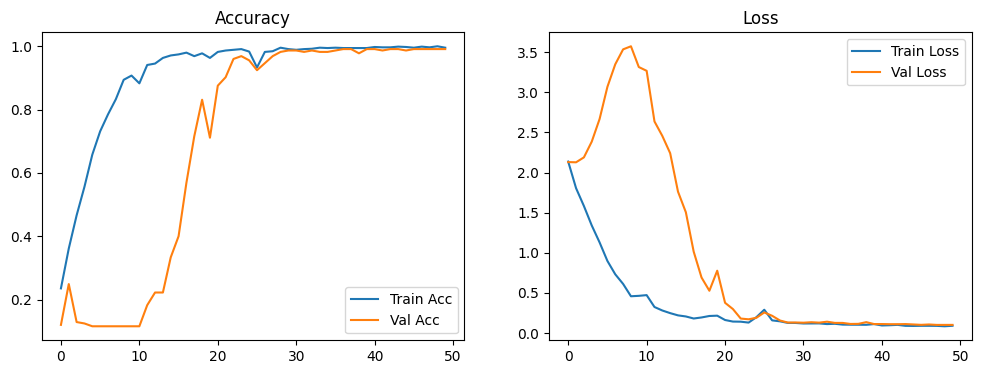

In [30]:
# 🔹 Plot Accuracy and Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

In [31]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.save("crnn_model_final.keras")

In [32]:
model.summary()  # Check if input shape is correct

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 29, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 29, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 7, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 7, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 32, 224)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,208 (231.28 KB)

 Trainable params: 59,112 (230.91 KB)

 Non-trainable params: 96 (384.00 B)

In [33]:
from ipynb.fs.full import test_model
from ipynb.fs.full import data_split

X_test = test_model.X_test
classes = data_split.classes

X_test = np.array(X_test)
print(X_test.shape)
print(classes)

(12, 128, 29)
['dha', 'ga', 'ma', 'ni', 'pa', 're', 'sa', "sa'"]


In [34]:
X_test = np.expand_dims(X_test, axis=-1)
print(X_test.shape)

predictions = model.predict(X_test)
print(predictions)

(12, 128, 29, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
[[1.77999143e-04 3.00494896e-04 5.82333450e-06 1.13001326e-04
  2.68988733e-05 1.09887324e-05 2.48764437e-02 9.74488318e-01]
 [1.96414421e-05 8.27326119e-01 1.21042877e-01 3.01854743e-04
  4.77900585e-06 3.38467658e-02 1.33088743e-02 4.14899876e-03]
 [8.61341960e-06 9.90197301e-01 2.60629971e-03 9.44338808e-06
  5.48452408e-06 3.20475316e-04 5.42011065e-03 1.43233128e-03]
 [4.06917934e-05 5.23062656e-03 6.42019510e-01 1.06290519e-01
  7.91088169e-05 2.40794584e-01 3.11905285e-03 2.42597237e-03]
 [2.04844531e-04 4.53392073e-04 3.06042130e-05 8.22044734e-04
  2.29822719e-04 1.90864284e-05 1.73470899e-01 8.24769258e-01]
 [6.52720064e-06 9.71961021e-01 2.32640374e-02 4.50273437e-05
  5.08000676e-06 6.24894514e-04 1.70922594e-03 2.38420069e-03]
 [1.20962977e-06 5.18678629e-04 9.84657109e-01 4.70514875e-03
  3.69853092e-06 1.00104064e-02 4.19614153e-05 6.18296981e-05]
 [7.50052495e-05 2.07807752e-04 6.55842450e-06 4.51708256e-05
  3.029

In [35]:
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

[7 1 1 2 7 1 2 7 4 3 0 3]


In [36]:
predicted_class_names = [classes[idx] for idx in predicted_classes]

In [37]:
predicted_class_names

["sa'", 'ga', 'ga', 'ma', "sa'", 'ga', 'ma', "sa'", 'pa', 'ni', 'dha', 'ni']